In [ ]:
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from random import randrange
sns.set(rc={'figure.figsize':(15,8)})

In [ ]:
df = pd.read_csv("./data/abalone.data", names=["sex", "length", "diameter", "height", "whole_weight", "shucked_weight", "viscera_weight", "shell_weight", "rings"])

In [ ]:
raw_abs = df.copy()
raw_abs

In [ ]:
raw_abs.loc[raw_abs['rings'].between(0, 7,inclusive='both'), 'ring_class'] = int(1)
raw_abs.loc[raw_abs['rings'].between(8, 10,inclusive='both'), 'ring_class'] = int(2)
raw_abs.loc[raw_abs['rings'].between(11, 15,inclusive='both'), 'ring_class'] = int(3)
raw_abs.loc[raw_abs['rings'] > 15, 'ring_class'] = int(4)
raw_abs['ring_class'] = raw_abs['ring_class'].astype(int)

In [ ]:
raw_abs.drop(columns = "rings", axis=1, inplace=True)


In [ ]:
num_pipeline = Pipeline([
    ('Nomalisation', MinMaxScaler()),
    ])

sex_pipeline = Pipeline([
    ('ord_encoder', OrdinalEncoder(categories=[['M', 'F', 'I']]))
])

ringClass_pipeline = Pipeline([
    ('ringClass_1Hot', OneHotEncoder())
])

num_arribs = list(raw_abs.drop(columns=["sex", "ring_class"]))

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_arribs),
    ("sex", sex_pipeline, ['sex']),
    ("ringClass_1Hot", ringClass_pipeline, ['ring_class'])
])



In [ ]:
abs_prepared = pd.DataFrame(full_pipeline.fit_transform(raw_abs))
abs_prepared

In [ ]:
X = abs_prepared.iloc[:,:-4]
y = abs_prepared.iloc[:,-4:]

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.4, random_state=42)

In [ ]:
# def init_model(hidden_neurons, hidden_layers = 1):
#     if hidden_layers == 1:
#         model = keras.models.Sequential([
#             keras.layers.InputLayer(input_dim = 7),
#             keras.layers.Dense(hidden_neurons, activation = "relu"),
#             keras.layers.Dense(4, activation = "softmax")
#         ])
#         return(model)
#     else:
#         model = keras.models.Sequential([
#             keras.layers.InputLayer(input_dim = 7),
#             keras.layers.Dense(hidden_neurons, activation = "relu"),
#             keras.layers.Dense(hidden_neurons, activation = "relu"),
#             keras.layers.Dense(4, activation = "softmax")
#         ])
#         return(model)

In [ ]:
X_train.shape

In [50]:
def run_model(hidden_neurons, lr=0.01):
    model = keras.models.Sequential([
    keras.layers.Dense(hidden_neurons, input_shape = (8,), activation = "relu"),
    # keras.layers.Dense(32, activation = "relu"),
    keras.layers.Dense(4, activation = "softmax")
])

    model.compile(loss = 'categorical_crossentropy',
              optimizer = keras.optimizers.SGD(learning_rate=lr),
              metrics = ['accuracy']
              )

    history = model.fit(X_train, y_train, epochs=50, batch_size=5, validation_split=0.1, verbose=0)

    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.savefig(".\\images\\1_layer_" + str(hidden_neurons) +"_hidden_nur.png", bbox_inches='tight')
    plt.show()


c:\Users\Dominic\Documents\UNSW\2022H5 Data mining and Machine Learning\.venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


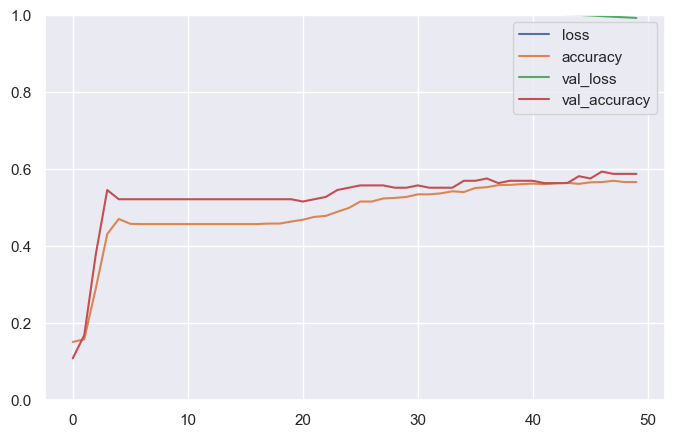

In [51]:
run_model(hidden_neurons=20, lr = 0.001)

In [ ]:
list(map(lambda x: run_model(x), [5,10,15,20]))